In [17]:
import scPhyloX as spx
import numpy as np
import arviz as az
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Bio import Phylo
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from scipy.stats import poisson

In [18]:
import os
os.chdir('../')

In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype']=42

In [6]:
# with gzip.open('./datasets/hek293t/Supplementary_File_2_DataTableMOI19.csv.gz', 'r') as f:
#     muttable = pd.read_csv(f, index_col=0)
muttable = pd.read_csv('./datasets/hek293t/Supplementary_File_2_DataTableMOI19.csv', index_col=0)
tree = Phylo.read('./datasets/hek293t/tr.nwk', format='newick')
sel_cells = [i.name for i in tree.get_terminals()]
mutnum = np.array([(~pd.isnull(muttable.loc[i].iloc[:,1:6])).sum().sum() for i in sel_cells])

In [23]:
sel_cell500 = np.random.choice(sel_cells, 500, replace=False)

In [31]:
tarbc = np.sort(muttable['TargetBC'].unique())

In [75]:
with open('./datasets/hek293t/seq_500.fa', 'w') as f:
    for c in sel_cell500:
        f.write(f'>{c}\n')
        
        seq_tmp = []
        for bc in tarbc:
            bc_mut = muttable.loc[c][muttable.loc[c]['TargetBC']==bc]
            if bc_mut.shape[0] == 0:
                # seq_tmp.append([None]*5)
                seq_tmp.append([0]*5)
            else:
                # seq_tmp.append(list(bc_mut.iloc[:,1:6].to_numpy().flatten()))
                seq_tmp.append(list(bc_mut.iloc[:,1:6].to_numpy().flatten()))
        seq_tmp = sum(seq_tmp, [])
        seq_tmp = ['1' if type(i)==str else '0' for i in seq_tmp]
        f.write(''.join(seq_tmp)+'\n')

In [7]:
ge = spx.est_mr.GenerationEst(mutnum, 3)
gen_num = ge.estimate(1e7)

In [8]:
T = 40

In [ ]:
res_de = spx.est_tissue.para_inference_DE(gen_num, T=T, sigma=10000, n_iter=150, bootstrape=5)

In [14]:
axh, bxh, rh, dh, kh, t0h,c0 = res_de[0][-1]
dh = 10**(-dh)
res_de = (axh, bxh, rh, dh, kh, t0h)

In [19]:
idata = spx.est_tissue.mcmc_inference(gen_num, res_de, T, c0, sigma=10000)

Population sampling (8 chains)
DEMetropolis: [ax, bx, r, k, t0, d]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:815: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:815: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:815: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:815: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:815: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/wangkun/miniconda3/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:815: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/wangkun/miniconda3/lib

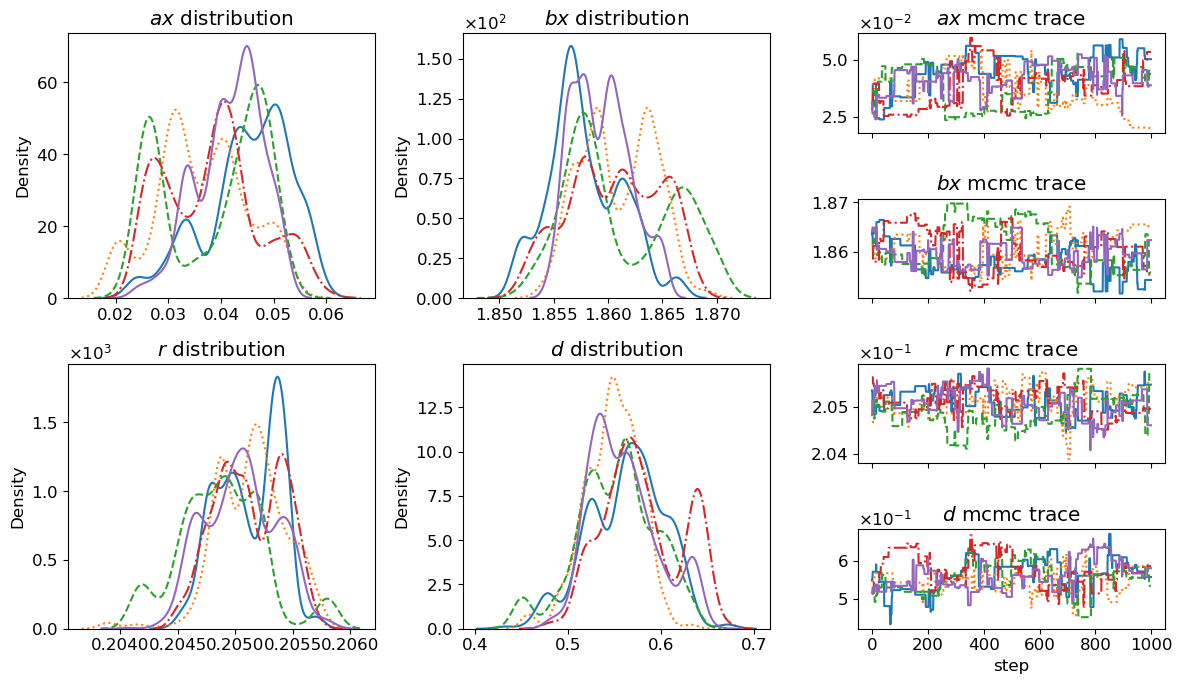

In [32]:
fig = plt.figure(figsize=(12,7))
plt.rcParams['font.size'] = 12
# gt = [0.32, 1, 1.3, 0.8, 8, 0.2]
gs = GridSpec(4, 3, figure=fig)
ls = 'solid.dotted.dashed.dashdot.solid'.split('.')
for ind, sym in enumerate('ax,bx,r,d'.split(',')):
    if ind >= 2:
        ax = fig.add_subplot(gs[2:, ind-2])
    else:
        ax = fig.add_subplot(gs[:2, ind])
    for i, l in enumerate(ls):   
        sns.kdeplot(idata.posterior[sym].to_numpy()[i], linestyle=l, ax=ax, label=f'Chain {i+1}')
    # ax1.legend(fontsize=10,loc=2)
    ylim = ax.get_ylim()
    # ax.vlines(gt[ind], *ylim, color='black')
    ax.set_ylim(ylim)
    ax.set_title(fr'${sym}$ distribution')
    ax.ticklabel_format(style='sci', scilimits= (-1,2), axis='y',useMathText=True)

ax0 = fig.add_subplot(gs[-1, 2])
for i, l in enumerate(ls): 
    ax0.plot(idata.posterior['d'][i], linestyle=l, label=f'Chain {i+1}')
    ax0.set_title(fr'$d$ mcmc trace')
    ax0.ticklabel_format(style='sci', scilimits= (-1,2), axis='y',useMathText=True)
for ind, sym in enumerate('ax,bx,r'.split(',')):
    ax = fig.add_subplot(gs[ind, 2], sharex=ax0)
    for i, l in enumerate(ls): 
        ax.plot(idata.posterior[sym][i], linestyle=l, label=f'Chain {i+1}')
        ax.set_title(fr'${sym}$ mcmc trace')
        ax.ticklabel_format(style='sci', scilimits= (-1,2), axis='y',useMathText=True)
    plt.setp(ax.get_xticklabels(), visible=False)
ax0.set_xlabel('step')
plt.tight_layout()

In [33]:
theta_h = az.summary(idata).loc['ax,bx,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()

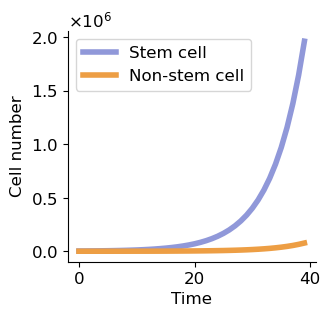

In [34]:
x0 = [c0, 0]
n_cyclingcells = np.array([[spx.est_tissue.ncyc(i, j, c0, *theta_h) for j in range(T)] for i in range(100)])
n_noncyclingcells = np.array([[spx.est_tissue.nnc(i, j, c0, *theta_h) for j in range(T)] for i in range(100)])
# sol = solve_ivp(cellnumber, t_span=(0, K), y0=x0, 
#                 method='RK45', args=(a, b, k, t0, p, r, d))
fig, axes = plt.subplots(1, 1, figsize=(3.2,3))
# ax[0].plot(sol.t, sol.y[0], label='Ec', c='tab:grey', lw=4, alpha=0.7)
# ax[0].plot(sol.t, sol.y[1], label='En', c='tab:purple', lw=4, alpha=0.7)
# axes.legend()
axes.set_xlabel('Time')
axes.set_ylabel('Cell number')

axes.plot(n_cyclingcells.sum(0), c='#9098d9', lw=4, label='Stem cell')
axes.plot(n_noncyclingcells.sum(0), c='#ed9e44', lw=4, label='Non-stem cell')
# axes.set_title(f'{fly} {organ}')
axes.ticklabel_format (style='sci', scilimits= (-1,2), axis='y', useMathText=True)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.legend(loc=2)
# plt.tight_layout()

In [9]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import loompy
from Bio import Phylo
import phylovelo as pv
from matplotlib import font_manager
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [10]:
data_path = '/data3/wangkun/phylovelo_datasets/jh/'
adata = scv.read(data_path + 'combined.loom', cache=False)
datatable = pd.read_csv(data_path + 'Supplementary_File_2_DataTableMOI19.csv', index_col=0)
tree = Phylo.read(data_path+'tr.nwk', format='newick')
selected_cells = [i.name.replace('-1',"x") for i in tree.get_terminals()]
cells_SRR18280236 = ["SRR18280236:"+i for i in selected_cells]
selected_cells_SRR18280236 = list(set(cells_SRR18280236).intersection(set(adata.obs.index.to_list())))
unselected_cells_SRR18280236 = list(set(cells_SRR18280236).difference(set(selected_cells_SRR18280236)))
cells_SRR18280237 = [cell.replace("SRR18280236","SRR18280237") for cell in unselected_cells_SRR18280236]
selected_cells_SRR18280237 = list(set(cells_SRR18280237).intersection(set(adata.obs.index.to_list()))) 
selected_cells = selected_cells_SRR18280236 + selected_cells_SRR18280237
selected_cells.sort()
sd = pv.scData()
sd.phylo_tree = tree
adata1 = adata[selected_cells,]
adata1.var_names_make_unique()
sd.count = pd.DataFrame(data=adata1.X.A, index=adata1.obs_names, columns=adata1.var_names)
scv.pp.filter_and_normalize(adata1,min_shared_counts=20)
sd.x_normed = pd.DataFrame(data=adata1.X.A, index=adata1.obs_names, columns=adata1.var_names)

Filtered out 29903 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [11]:
scv.tl.tsne(adata1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [12]:
sd.cell_names = sd.x_normed.index
sd.Xdr = pd.DataFrame(data=adata1.obsm['X_tsne'], index=adata1.obs_names)
sd.Xdr = sd.Xdr.loc[sd.cell_names]

In [13]:
mutnum = [(~pd.isnull(datatable.loc[i[12:].replace('x', '-1')].iloc[:,1:6])).sum().sum() for i in sd.x_normed.index]

In [14]:
generation = np.array([ge.generation_map(i) for i in mutnum])

In [15]:
pv.velocity_inference(sd, generation, target='x_normed')
pv.velocity_embedding(sd, target='x_normed')
pv.calc_phylo_pseudotime(sd, 30, 0.3)

  0%|          | 0/6698 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/973 [00:00<?, ?it/s]

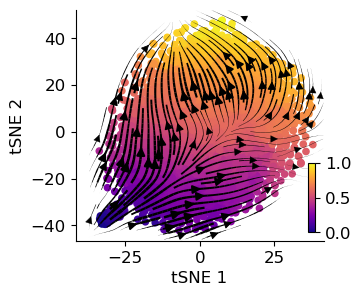

In [16]:
fig, ax = plt.subplots(figsize=(3.2, 3))
scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=20, c=sd.phylo_pseudotime,cmap='plasma')
ax = pv.velocity_plot(sd.Xdr.to_numpy(), -sd.velocity_embeded, ax, 'stream', grid_density=25, radius=5, lw_coef=6000, arrowsize=1.2)
ax.set_xlabel('tSNE 1', fontsize=12)
ax.set_ylabel('tSNE 2', fontsize=12)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)